<a href="https://colab.research.google.com/github/Kyoung-mii/DeepLearning/blob/main/03_DeepLearningFramwork/3_4_ImplementingModelsUsingKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.4.1 텐서플로를 이용한 다층 퍼셉트론 학습

## 1) 학습 데이터의 준비 등 사전 작업

### 3-6 [1] 필요한 패키지 불러오기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses

### 3-6 [2] 데이터 준비 함수 정의하기

In [2]:
def prepare_data():
    iris = load_iris()  # iris data set 읽기
    X = iris.data[:, 2:] # 4개의 특징 중 꽃잎의 길이와 폭 선택
    y = iris.target # 각 표본의 레이블
    lbl_str = iris.target_names #'setosa','versicolor','virginica'
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = 0.20)
    return X_tr, y_tr, X_val, y_val, lbl_str

### 3-6 [3] 분류 결과의 시각화 함수 정의

In [4]:
def visualize(net, X, y, multi_class, labels, class_id, colors,
              xlabel, ylabel, legend_loc = 'lower right'):
    # 데이터의 최소~최대 범위를 0.25 간격의 좌표값으로 나열
    x_max = np.ceil(np.max(X[:,0])).astype(int)
    x_min = np.floor(np.min(X[:, 0])).astype(int)
    y_max = np.ceil(np.max(X[:, 1])).astype(int)
    y_min = np.floor(np.min(X[:, 1])).astype(int)
    x_lin = np.linspace(x_min, x_max, (x_max - x_min) * 20 + 1)
    y_lin = np.linspace(y_min, x_max, (y_max - y_min) * 20 + 1)

    # x_lin과 y_lin의 격자좌표의 x와 y값 구하기
    x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)

    # (x, y) 좌표의 배열로 만들어 신경망의 입력 구성
    X_test = np.column_stack([x_mesh.ravel(), y_mesh.ravel()])

    # 학습된 신경망으로 X_test에 대한 출력 계산
    if multi_class:
        y_hat = net.predict(X_test)
        y_hat = np.array([np.argmax(y_hat[k]) for k in range(len(y_hat))],
                         dtype = int)
    else:
        y_hat = (net.predict(X_test) >= 0.5).astype(int)
        y_hat = y_hat.reshape(len(y_hat))

    # 출력할 그래프의 수평/수직 범위 및 각 클래스에 대한 색상 및 범례 설정
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # 클래스별로 산점도 그리기
    for c, i, c_name in zip(colors, labels, class_id):
        # 격자 좌표의 클래스별 산점도
        plt.scatter(X_test[y_hat == i, 0], X_test[y_hat == i, 1],
                    c = c, s = 5, alpha = 0.3, edgecolors = 'none')
        # 학습 표본의 클래스별 산점도
        plt.scatter(X[y==i, 0], X[y==i, 1],
                    c = c, s = 20, label = c_name)
    # 범례의 표시 위치 지정
    plt.legend(loc = legend_loc)
    # x축과 y축의 레이블을 지정한 후 그래프 출력
    plt.xlabel(xlabel, size = 12)
    plt.ylabel(ylabel, size = 12)
    plt.show()

### 3-6 [4] 훈련 데이터 준비하기

In [15]:
nSamples = 150
nDim = 2
nClasses = 3
X_tr, y_tr, X_val, y_val, labels = prepare_data()

## 2) 모델의 정의

### 3-6 [5] 모델 구성

In [16]:
bp_model_tf = keras.Sequential()
bp_model_tf.add(layers.InputLayer(shape = (nDim,)))
bp_model_tf.add(layers.Dense(4, activation = 'sigmoid'))
bp_model_tf.add(layers.Dense(nClasses, activation='softmax'))

### 3-6a [5] 모델 구성 : 함수형 api를 이용한 모델 정의

In [25]:
inputs = keras.Input(shape = (nDim, ))
h = layers.Dense(4, activation = 'sigmoid')(inputs)
y = layers.Dense(nClasses, activation = 'softmax')(h)
bp_model_tf = keras.Model(inputs, y)
bp_model_tf.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 27 (108.00 B)

 Non-trainable params: 0 (0.00 B)

### 3-6b [5] 모델 클래스 선언 및 모델 인스턴스 : 서브클래싱 api를 이용한 모델 정의

In [27]:
class BP_iris(keras.Model):
    def __init__(self):
        super(BP_iris, self).__init__()
        self.h_layer = layers.Dense(4, activation = 'sigmoid')
        self.o_layer = layers.Dense(nClasses, activation = 'softmax')

    def call(self, x):
        x = self.h_layer(x)
        return self.o_layer(x)

bp_model_tf = BP_iris()
bp_model_tf.summary()

Model: "bp_iris_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 3) 모델의 요약 정보 출력

### 3-6 [6] 모델의 요약 정보 출력

In [17]:
bp_model_tf.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27 (108.00 B)

 Trainable params: 27 (108.00 B)

 Non-trainable params: 0 (0.00 B)

## 4) 모델의 컴파일

### 3-6 [7] 모델의 컴파일

In [18]:
bp_model_tf.compile(optimizer = optimizers.SGD(0.1, momentum = 0.9),
                    loss = losses.SparseCategoricalCrossentropy(),
                    metrics = ['accuracy'])

## 5) 모델의 학습

### 3-6 [8] 모델의 학습

In [22]:
bp_model_tf.fit(X_tr, y_tr, batch_size = 15, epochs = 1000, verbose = 2,
                validation_data = (X_val, y_val))

Epoch 1/1000
8/8 - 1s - 83ms/step - accuracy: 0.1500 - loss: 1.2015 - val_accuracy: 0.3000 - val_loss: 1.1382
Epoch 2/1000
8/8 - 0s - 13ms/step - accuracy: 0.3750 - loss: 1.1099 - val_accuracy: 0.6000 - val_loss: 1.0591
Epoch 3/1000
8/8 - 0s - 12ms/step - accuracy: 0.6417 - loss: 1.0358 - val_accuracy: 0.6333 - val_loss: 0.9916
Epoch 4/1000
8/8 - 0s - 12ms/step - accuracy: 0.6417 - loss: 0.9510 - val_accuracy: 0.7667 - val_loss: 0.8919
Epoch 5/1000
8/8 - 0s - 12ms/step - accuracy: 0.5917 - loss: 0.8379 - val_accuracy: 0.6333 - val_loss: 0.7879
Epoch 6/1000
8/8 - 0s - 12ms/step - accuracy: 0.6250 - loss: 0.7388 - val_accuracy: 0.7000 - val_loss: 0.6710
Epoch 7/1000
8/8 - 0s - 12ms/step - accuracy: 0.7000 - loss: 0.6302 - val_accuracy: 0.6333 - val_loss: 0.6055
Epoch 8/1000
8/8 - 0s - 12ms/step - accuracy: 0.7083 - loss: 0.5764 - val_accuracy: 1.0000 - val_loss: 0.5417
Epoch 9/1000
8/8 - 0s - 12ms/step - accuracy: 0.8167 - loss: 0.5271 - val_accuracy: 0.9667 - val_loss: 0.5006
Epoch 10/1

## 6) 훈련된 모델을 이용한 분류

### 3-6 [9] 훈련된 모델을 이용한 분류

In [23]:
y_hat = bp_model_tf.predict(X_val, verbose = 0)
y_hat_lbls = np.array([np.argmax(y_hat[k])
               for k in range(len(X_val))])
nCorrect = (y_hat_lbls == y_val).sum()
print('Validation accuracy: {}/{} --> {:7.3f}%'.
      format(nCorrect, len(X_val), nCorrect * 100.0 / len(X_val)))

Validation accuracy: 30/30 --> 100.000%


## 7) 특징 공간 결정 영역 시각화

### 3-6 [10] 특징 공간 결정 영역 시각화

231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


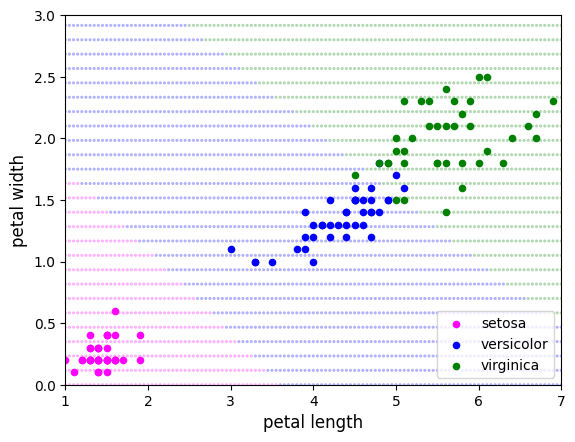

In [24]:
visualize(bp_model_tf, X_tr, y_tr,
          multi_class = True,
          class_id = labels,
          labels = [0,1,2],
          colors = ['magenta','blue','green'],
          xlabel = 'petal length',
          ylabel = 'petal width')